In [1]:
import gym
import minerl
import matplotlib.pyplot as plt

import gc
import numpy as np
from tqdm import tqdm
from timeit import default_timer as timer
from collections import OrderedDict

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset

C:\Users\mateu\AppData\Roaming\Python\Python39\site-packages\gym\logger.py:34: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize("%s: %s" % ("WARN", msg % args), "yellow"))
C:\Users\mateu\AppData\Roaming\Python\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data = minerl.data.make("MineRLTreechop-v0")

In [3]:
noise_dim = 16

trajectory_names = data.get_trajectory_names()
trajectories = [[x for x in data.load_data(k)] for k in trajectory_names[:-32]]
trajectory_lens = [len(t) for t in trajectories]
noise_arr = [np.random.randn(l, noise_dim) for l in trajectory_lens]

trajectories_eval = [[x for x in data.load_data(k)] for k in trajectory_names[-32: ]]
trajectory_lens_eval = [len(t) for t in trajectories_eval]
noise_arr_eval = [np.random.randn(l, noise_dim) for l in trajectory_lens_eval]


100%|██████████████████████████████████████████████████████████████████████████| 1767/1767 [00:00<00:00, 110410.95it/s]


100%|██████████████████████████████████████████████████████████████████████████| 2131/2131 [00:00<00:00, 133153.50it/s]


100%|██████████████████████████████████████████████████████████████████████████| 2176/2176 [00:00<00:00, 135971.36it/s]


100%|██████████████████████████████████████████████████████████████████████████| 1964/1964 [00:00<00:00, 122715.01it/s]


In [4]:
i = 0

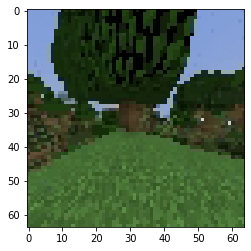

In [5]:
i += 1
plt.imshow(trajectories[0][i][0]['pov'])

In [6]:
#generate a query from state vector
#query the gnn to obtain the next macro action
#combine state and macro action into conditional distribution of micro actions

#challenges:
#gnn should compress the gameplan (set of macro actions for solving env)

In [7]:
len(trajectory_names)

209

In [8]:
batch_size = 32
seq_len = 256
noise_dim = 16


In [9]:
test_rew = [x[2] for x in trajectories[0]]

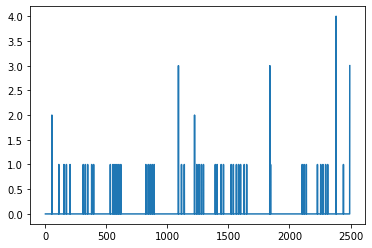

In [10]:
plt.plot(test_rew)

In [11]:
def discounted_reward(rewards):
    gamma = 0.99
    ret = []
    cumulative_reward = 0.
    for r in reversed(rewards):
        cumulative_reward = r + gamma * cumulative_reward
        ret.insert(0, cumulative_reward)
        
    return ret

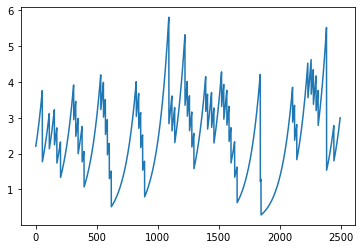

In [12]:
plt.plot(discounted_reward(test_rew))

In [13]:
discounted_rewards = [discounted_reward([x[2] for x in trajectories[i]]) for i in range(len(trajectories))]
discounted_rewards_eval = [discounted_reward([x[2] for x in trajectories_eval[i]]) for i in range(len(trajectories_eval))]

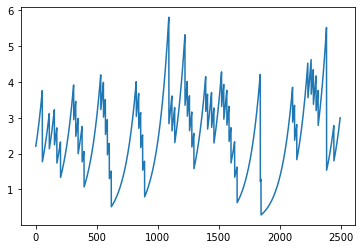

In [14]:
plt.plot(discounted_rewards[0])

In [15]:
n_sequences_per_trajectory = {k: np.ceil(l / seq_len).astype(np.int32) for k, l in enumerate(trajectory_lens)}
n_sequences_per_trajectory_eval = {k: np.ceil(l / seq_len).astype(np.int32) for k, l in enumerate(trajectory_lens_eval)}
# remaining_steps_per_trajectory = {k: len(t) for k, t in enumerate(trajectories)}

In [16]:
# any(remaining_steps_per_trajectory.values())

In [17]:
# n_sequences_per_trajectory

In [18]:
def get_batch_master_list(trajectories):
    concat_batch_len = np.zeros((batch_size, ), dtype=np.int32)
    trajectory_inds = list(range(len(trajectories)))
    np.random.shuffle(trajectory_inds)

    batch_master_list = [[] for i in range(batch_size)]
    trajectory_lens = [len(t) for t in trajectories]
    n_sequences_per_trajectory = {k: np.ceil(l / seq_len).astype(np.int32) for k, l in enumerate(trajectory_lens)}

    while trajectory_inds:
        min_inds = np.where(concat_batch_len == concat_batch_len.min())[0]
        for ind in min_inds:
            if not trajectory_inds:
                break
            ti = trajectory_inds.pop()
            n_seqs = n_sequences_per_trajectory[ti]
            #construct tuples
            entries = []
            for n in range(n_seqs):
                valid_steps = min(trajectory_lens[ti] - n * seq_len, seq_len)
                entry = (ti, n, valid_steps)
                entries.append(entry)
            batch_master_list[ind].extend(entries)
            concat_batch_len[ind] += n_seqs
            
    gen_len = max([len(x) for x in batch_master_list])
    
    return batch_master_list, gen_len

In [19]:
def get_batch_metadata(batch_master_list, ind):
    ret = [b[ind] if ind < len(b) else None for b in batch_master_list]
    return ret   

In [20]:
def map_action(action):
    action = OrderedDict(action)
    camera = action.pop('camera') / 180.
    ret = np.array(list(action.values()), dtype=np.float32)
    ret = np.concatenate([ret, camera])
    return ret

In [21]:
# map_action(test_action)

In [22]:
action_dim = 10

def get_batch(batch_metadata, trajectories, discounted_rewards, noise_arr):
    reset_list = [x[1] == 0 if x else False for x in batch_metadata]
    povs = np.zeros((batch_size, seq_len, 64, 64, 3), dtype=np.float32)
    loss_masks = np.zeros((batch_size, seq_len), dtype=np.float32)
    rewards = np.zeros((batch_size, seq_len), dtype=np.float32)
    actions = np.zeros((batch_size, seq_len, action_dim), dtype=np.float32)
    noise = np.zeros((batch_size, seq_len, noise_dim), dtype=np.float32)
    
    for i, bm in enumerate(batch_metadata):
        if not bm:
            continue
        valid_steps = bm[2]
        loss_masks[i, :valid_steps] = np.ones((valid_steps, ), dtype=np.float32)
        
        trajectory_ind = bm[0]
        chunk_ind = bm[1]
        trajectory = trajectories[trajectory_ind]
        t_start = seq_len * chunk_ind
        t_end = t_start + valid_steps
        pov_stack = np.stack([sarsd[0]['pov'] for sarsd in trajectory[t_start: t_end]])
        povs[i, :valid_steps] = pov_stack / 255.
        
        rewards[i, :valid_steps] = discounted_rewards[trajectory_ind][t_start: t_end]
        
        actions[i, :valid_steps] = np.stack([map_action(sarsd[1]) for sarsd in trajectory[t_start: t_end]])
        
        noise[i, :valid_steps] = noise_arr[trajectory_ind][t_start: t_end]
        
    
    return povs, loss_masks, reset_list, rewards, actions, noise

In [23]:
### add action conditiong to lstm - projecting action and adding to input should be equivalent
### add evaluation
### internal state prediction in n nitmesteps

In [24]:
class ConvBlock(nn.Module):
    def __init__(self, in_filters, out_filters, stride=2, block_type='conv', skip_relu=False, kernel_size=3):
        super().__init__()   
        if block_type == 'conv':
            self.conv = nn.Conv2d(in_filters, out_filters, stride=stride, padding=1, kernel_size=3)
        elif block_type == 'deconv':
            self.conv = nn.ConvTranspose2d(in_filters, out_filters, stride=stride, padding=1, kernel_size=3, output_padding=stride-1)
        self.bn = nn.BatchNorm2d(out_filters)
        self.skip_relu = skip_relu
    
    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if not self.skip_relu:
            x = F.relu(x)
        return x    

p_dim = 48    
    
class ContrastNet(nn.Module):
    def __init__(self, lstm_size):
        super().__init__()
        self.conv_encoder = nn.Sequential(
            ConvBlock(3, 16),
            ConvBlock(16, 32),
            ConvBlock(32, 64),
            ConvBlock(64, 128),
            ConvBlock(128, 128, 1),
            ConvBlock(128, 128, kernel_size=2),
            nn.Flatten(),
            nn.Linear(128 * 2 * 2, lstm_size)
        )
        self.lstm = nn.LSTM(input_size=lstm_size, hidden_size=lstm_size, batch_first=True)

        self.p1 = nn.Linear(lstm_size, p_dim, bias=False)
        self.p2 = nn.Linear(lstm_size, p_dim, bias=False) 
        self.logit_scale = nn.Parameter(torch.zeros([], dtype=torch.float32))

    
    def forward(self, povs, h0, c0):
        povs = torch.permute(povs, (0, 1, 4, 2, 3)).view(-1, 3, 64, 64)
        enc = self.conv_encoder(povs).view(batch_size, seq_len, -1)
        lstm_out, (h, c) = self.lstm(enc, (h0, c0)) #lstm_out is s(t) - (bs, seq_len, lstm_size)
        
        p1 = self.p1(lstm_out)
        p2 = self.p1(lstm_out)
        
        p1 = p1 / p1.norm(dim=-1, keepdim=True)
        p2 = p2 / p2.norm(dim=-1, keepdim=True)
        
        logits = torch.einsum('bik,cjk->bcij', p1, p2) * F.softplus(self.logit_scale) #(bs, bs, seq_len, seq_len)
#         logits = logits - (1. - logit_mask) * 1e16 
        
        return h, c, logits

In [25]:
lstm_size = 128
intent_dim = 64

model = ContrastNet(lstm_size=lstm_size).cuda()
criterion = nn.MSELoss(reduction='none')
binary_criterion = nn.BCELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)

In [26]:
sum(p.numel() for p in model.parameters())

603649

In [27]:
# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.numel())

In [28]:
# dummy_inp = torch.zeros((32, 256, 64, 64, 3)).cuda()
# h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
# c0 = torch.zeros_like(h0)
# model(dummy_inp, h0, c0)

In [29]:
sum(p.numel() for p in model.parameters())

603649

In [30]:
sum(p.numel() for p in model.parameters())

603649

In [27]:
# def double_loss(logits, target, mask):
#     #logits is (bs, bs, seq_len, seq_len)
#     #target is (bs, seq_len, seq_len)
#     p1_loss = F.cross_entropy(logits, target, reduction='none')
#     p2_loss = F.cross_entropy(torch.permute(logits, (1, 0, 2, 3)), target, reduction='none')
#     out = p1_loss * mask[0] + p2_loss * mask[:, 0]
#     return out.mean()

def double_loss(logits, target, mask):
    #logits is (bs, bs, seq_len, seq_len)
    #target is (bs, bs, seq_len, seq_len)
    
    #mask logits
    logits = logits - (1. - mask.view(1, batch_size, 1, seq_len)) * 1e16
    
    loss = F.cross_entropy(logits, target, reduction='none')    
    loss = loss * mask.view(batch_size, 1, seq_len)
    
    scale = torch.log(torch.tensor(batch_size)) / torch.log(torch.clip(mask.sum(dim=0), min=2))
    scale = torch.einsum('i,j->ij', scale, scale).view(1, seq_len, seq_len)
    
    loss = loss * scale    
    loss = loss.mean()
    
    return loss

In [28]:
# import gc
# gc.collect()
# torch.cuda.empty_cache()

In [33]:
num_epochs = 1000
outputs = []

# target = torch.tile(torch.arange(0, batch_size).view(batch_size, 1, 1), (1, seq_len, seq_len)).cuda()
target = torch.tile(torch.eye(batch_size).view(batch_size, batch_size, 1, 1), (1, 1, seq_len, seq_len)).cuda()


for epoch in range(num_epochs):
    
    model.train()
    loss_sum = 0.
    loss_denominator = 0.
    
    #reinit generator and states
    batch_master_list, gen_len = get_batch_master_list(trajectories)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
#     i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories, discounted_rewards, noise_arr)
        
        povs = torch.tensor(povs).cuda()
        loss_masks = torch.tensor(loss_masks).cuda()
#         logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)

        #stateful_lstm
        #input is  povs, h0, c0, noise, i0
        #output is h, c, final_it, pred_action_discrete, pred_action_camera
        for i, r in enumerate(reset_list):
            if r:
                h0[:, i] = torch.zeros_like(h0[:, i])
                c0[:, i] = torch.zeros_like(c0[:, i])

        h0, c0, logits = model(povs, h0, c0)
        
        h0 = h0.detach()
        c0 = c0.detach()
        
        #loss

        loss = double_loss(logits, target, loss_masks)
#         loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)
        optimizer.step()
        end = timer()
        print(f'Epoch {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
        
    
    print('')    
    #eval
    model.eval()
    loss_sum = 0.
    loss_denominator = 0.
    
    batch_master_list, gen_len = get_batch_master_list(trajectories_eval)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
    i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories_eval, discounted_rewards_eval, noise_arr_eval)
        
        povs = torch.tensor(povs).cuda() 
        loss_masks = torch.tensor(loss_masks).cuda()
        logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)
        
        for i, r in enumerate(reset_list):
            if r:
                h0[0, i] = torch.zeros_like(h0[0, i])
                c0[0, i] = torch.zeros_like(c0[0, i])
        
        with torch.no_grad():
            h0, c0, logits = model(povs, h0, c0)
        
        loss = double_loss(logits, target, loss_masks)
#         loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        end = timer()
        print(f'Eval {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
    
    print('')



C:\Users\mateu\AppData\Local\Temp\ipykernel_3540\2193626365.py:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)


Epoch 1 58 / 58 2.687734551470855 155.8886039853096 0.678803 sss
Eval 1 14 / 14 2.32043125799724 32.486037611961365 0.325231 sss
Epoch 2 53 / 53 2.8896247620852487 153.1501123905182 0.687552 ss
Eval 2 14 / 14 2.334872918469565 32.688220858573914 0.318453 ss
Epoch 3 54 / 54 3.0739646752675376 165.99409246444702 0.684109 s
Eval 3 14 / 14 2.3138256669044495 32.39355933666229 0.315798 s
Epoch 4 60 / 60 2.740187873442968 164.41127240657806 0.680873 ss
Eval 4 14 / 14 2.3369513962950026 32.717319548130035 0.305360 s
Epoch 5 53 / 53 2.9611750132632704 156.94227570295334 0.690868 s
Eval 5 14 / 14 2.249163563762392 31.488289892673492 0.293261 ss
Epoch 6 62 / 62 2.5109421726196044 155.67841470241547 0.697206 s
Eval 6 14 / 14 2.3289977737835477 32.605968832969666 0.317217 s


KeyboardInterrupt: 

In [33]:
num_epochs = 1000
outputs = []

# target = torch.tile(torch.arange(0, batch_size).view(batch_size, 1, 1), (1, seq_len, seq_len)).cuda()
target = torch.tile(torch.eye(batch_size).view(batch_size, batch_size, 1, 1), (1, 1, seq_len, seq_len)).cuda()


for epoch in range(num_epochs):
    
    model.train()
    loss_sum = 0.
    loss_denominator = 0.
    
    #reinit generator and states
    batch_master_list, gen_len = get_batch_master_list(trajectories)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
#     i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories, discounted_rewards, noise_arr)
        
        povs = torch.tensor(povs).cuda()
        loss_masks = torch.tensor(loss_masks).cuda()
#         logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)

        #stateful_lstm
        #input is  povs, h0, c0, noise, i0
        #output is h, c, final_it, pred_action_discrete, pred_action_camera
        for i, r in enumerate(reset_list):
            if r:
                h0[:, i] = torch.zeros_like(h0[:, i])
                c0[:, i] = torch.zeros_like(c0[:, i])

        h0, c0, logits = model(povs, h0, c0)
        
        h0 = h0.detach()
        c0 = c0.detach()
        
        #loss

        loss = double_loss(logits, target, loss_masks)
#         loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)
        optimizer.step()
        end = timer()
        print(f'Epoch {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
        
    
    print('')    
    #eval
    model.eval()
    loss_sum = 0.
    loss_denominator = 0.
    
    batch_master_list, gen_len = get_batch_master_list(trajectories_eval)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
    i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories_eval, discounted_rewards_eval, noise_arr_eval)
        
        povs = torch.tensor(povs).cuda() 
        loss_masks = torch.tensor(loss_masks).cuda()
        logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)
        
        for i, r in enumerate(reset_list):
            if r:
                h0[0, i] = torch.zeros_like(h0[0, i])
                c0[0, i] = torch.zeros_like(c0[0, i])
        
        with torch.no_grad():
            h0, c0, logits = model(povs, h0, c0)
        
        loss = double_loss(logits, target, loss_masks)
#         loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        end = timer()
        print(f'Eval {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
    
    print('')



C:\Users\Lugi\AppData\Local\Temp\ipykernel_19600\2193626365.py:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)


Epoch 1 55 / 55 2.804831859469414 154.26575227081776 1.025393 ss
Eval 1 18 / 18 1.653510679801305 29.763192236423492 0.325556 ss
Epoch 2 55 / 55 2.646448530392213 145.55466917157173 1.092220 ss
Eval 2 18 / 18 1.6987602379586961 30.57768428325653 0.391923 s
Epoch 3 58 / 58 2.702681388834427 156.75552055239677 1.130972 ss
Eval 3 18 / 18 1.6949771642684937 30.509588956832886 0.345819 s
Epoch 4 56 / 56 2.7682878353766034 155.02411878108978 1.138021 s
Eval 4 18 / 18 1.682149973180559 30.27869951725006 0.362311 sss
Epoch 5 63 / 63 2.541513593423934 160.11535638570786 1.130811 ss
Eval 5 18 / 18 1.6958070198694866 30.524526357650757 0.361918 s
Epoch 6 56 / 56 2.7477606604141847 153.87459698319435 1.131992 s
Eval 6 18 / 18 1.6292961537837982 29.327330768108368 0.371033 s
Epoch 7 56 / 56 2.770348553146635 155.13951897621155 1.125694 ss
Eval 7 18 / 18 1.7065656979878743 30.71818256378174 0.355065 ss
Epoch 8 57 / 57 2.7410892865114045 156.24208933115005 1.121637 s
Eval 8 18 / 18 1.6635983718766107

Eval 125 18 / 18 1.2461832960446675 22.431299328804016 0.347610 s
Epoch 126 59 / 59 0.750157134323302 44.259270925074816 1.006340 ss
Eval 126 18 / 18 1.3279676271809473 23.90341728925705 0.342594 ss
Epoch 127 61 / 61 0.8086545808950714 49.327929434599355 1.009853 s
Eval 127 18 / 18 1.3504296276304457 24.307733297348022 0.321193 s
Epoch 128 62 / 62 0.8244031727719572 51.11299671186134 1.009772 ss
Eval 128 18 / 18 1.0116721300615206 18.21009834110737 0.336085 ss
Epoch 129 55 / 55 0.8993504097346555 49.46427253540605 1.007117 ss
Eval 129 18 / 18 0.8022680050796933 14.440824091434479 0.350124 s
Epoch 130 54 / 54 0.8889493644366868 48.00326567958109 1.008715 ss
Eval 130 18 / 18 0.9169244824184312 16.50464068353176 0.333380 ss
Epoch 131 65 / 65 0.7053936860309198 45.85058959200978 1.010682 ss
Eval 131 18 / 18 1.2451432479752436 22.412578463554382 0.344765 s
Epoch 132 58 / 58 0.7619370337623846 44.192347958218306 1.009808 s
Eval 132 18 / 18 1.1146899229950376 20.064418613910675 0.337105 s
Epo

Epoch 256 54 / 54 nan nan 1.009344 s
Eval 256 18 / 18 nan nan 0.342548 s
Epoch 257 65 / 65 nan nan 1.008854 s
Eval 257 18 / 18 nan nan 0.349440 s
Epoch 258 57 / 57 nan nan 1.007717 s
Eval 258 18 / 18 nan nan 0.336771 s
Epoch 259 55 / 55 nan nan 1.008715 s
Eval 259 18 / 18 nan nan 0.337351 s
Epoch 260 58 / 58 nan nan 1.009281 s
Eval 260 18 / 18 nan nan 0.348564 s
Epoch 261 55 / 55 nan nan 1.009180 s
Eval 261 18 / 18 nan nan 0.344764 s
Epoch 262 60 / 60 nan nan 1.009835 s
Eval 262 18 / 18 nan nan 0.337161 s
Epoch 263 59 / 59 nan nan 1.008538 s
Eval 263 18 / 18 nan nan 0.339839 s
Epoch 264 55 / 55 nan nan 1.008910 s
Eval 264 18 / 18 nan nan 0.357619 s
Epoch 265 56 / 56 nan nan 1.008496 s
Eval 265 18 / 18 nan nan 0.345945 s
Epoch 266 58 / 58 nan nan 1.007913 s
Eval 266 18 / 18 nan nan 0.341817 s
Epoch 267 55 / 55 nan nan 1.008599 s
Eval 267 18 / 18 nan nan 0.335493 s
Epoch 268 58 / 58 nan nan 1.019823 s
Eval 268 18 / 18 nan nan 0.321932 s
Epoch 269 56 / 56 nan nan 1.009440 s
Eval 269 18 / 

Epoch 480 62 / 62 nan nan 1.009521 s
Eval 480 18 / 18 nan nan 0.338682 s
Epoch 481 62 / 62 nan nan 1.007007 s
Eval 481 18 / 18 nan nan 0.341442 s
Epoch 482 58 / 58 nan nan 1.011232 s
Eval 482 18 / 18 nan nan 0.346085 s
Epoch 483 58 / 58 nan nan 1.010385 s
Eval 483 18 / 18 nan nan 0.347994 s
Epoch 484 58 / 58 nan nan 1.010373 s
Eval 484 18 / 18 nan nan 0.339564 s
Epoch 485 60 / 60 nan nan 1.009258 s
Eval 485 18 / 18 nan nan 0.349536 s
Epoch 486 59 / 59 nan nan 1.026116 s
Eval 486 18 / 18 nan nan 0.333940 s
Epoch 487 57 / 57 nan nan 1.011538 s
Eval 487 18 / 18 nan nan 0.332231 s
Epoch 488 68 / 68 nan nan 1.008048 s
Eval 488 18 / 18 nan nan 0.338520 s
Epoch 489 60 / 60 nan nan 1.007062 s
Eval 489 18 / 18 nan nan 0.351916 s
Epoch 490 56 / 56 nan nan 1.011555 s
Eval 490 18 / 18 nan nan 0.364924 s
Epoch 491 58 / 58 nan nan 1.009032 s
Eval 491 18 / 18 nan nan 0.345775 s
Epoch 492 60 / 60 nan nan 1.013095 s
Eval 492 18 / 18 nan nan 0.338877 s
Epoch 493 56 / 56 nan nan 1.010855 s
Eval 493 18 / 

KeyboardInterrupt: 

In [33]:
num_epochs = 1000
outputs = []

# target = torch.tile(torch.arange(0, batch_size).view(batch_size, 1, 1), (1, seq_len, seq_len)).cuda()
target = torch.tile(torch.eye(batch_size).view(batch_size, batch_size, 1, 1), (1, 1, seq_len, seq_len)).cuda()


for epoch in range(num_epochs):
    
    model.train()
    loss_sum = 0.
    loss_denominator = 0.
    
    #reinit generator and states
    batch_master_list, gen_len = get_batch_master_list(trajectories)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
#     i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories, discounted_rewards, noise_arr)
        
        povs = torch.tensor(povs).cuda()
        loss_masks = torch.tensor(loss_masks).cuda()
#         logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)

        #stateful_lstm
        #input is  povs, h0, c0, noise, i0
        #output is h, c, final_it, pred_action_discrete, pred_action_camera
        for i, r in enumerate(reset_list):
            if r:
                h0[:, i] = torch.zeros_like(h0[:, i])
                c0[:, i] = torch.zeros_like(c0[:, i])

        h0, c0, logits = model(povs, h0, c0)
        
        h0 = h0.detach()
        c0 = c0.detach()
        
        #loss

        loss = double_loss(logits, target, loss_masks)
        loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)
        optimizer.step()
        end = timer()
        print(f'Epoch {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
        
    
    print('')    
    #eval
    model.eval()
    loss_sum = 0.
    loss_denominator = 0.
    
    batch_master_list, gen_len = get_batch_master_list(trajectories_eval)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
    i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories_eval, discounted_rewards_eval, noise_arr_eval)
        
        povs = torch.tensor(povs).cuda() 
        loss_masks = torch.tensor(loss_masks).cuda()
        logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)
        
        for i, r in enumerate(reset_list):
            if r:
                h0[0, i] = torch.zeros_like(h0[0, i])
                c0[0, i] = torch.zeros_like(c0[0, i])
        
        with torch.no_grad():
            h0, c0, logits = model(povs, h0, c0)
        
        loss = double_loss(logits, target, loss_masks)
        loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        end = timer()
        print(f'Eval {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
    
    print('')



C:\Users\Lugi\AppData\Local\Temp\ipykernel_14168\2895912800.py:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)


Epoch 1 54 / 54 5.662805472259168 305.7914955019951 1.045680 sss
Eval 1 17 / 17 4.038287660654853 68.65089023113251 0.340487 ss
Epoch 2 60 / 60 4.787081589798133 287.22489538788795 1.048775 ss
Eval 2 17 / 17 4.073472941623015 69.24904000759125 0.331447 ss
Epoch 3 65 / 65 4.6087231562687805 299.5670051574707 1.049240 ss
Eval 3 17 / 17 4.060808518353631 69.03374481201172 0.331800 sss
Epoch 4 53 / 53 5.795705681701876 307.17240113019943 1.045874 ss
Eval 4 17 / 17 3.9254898253609154 66.73332703113556 0.335542 s
Epoch 5 62 / 62 4.805092067487778 297.91570818424225 1.044905 s
Eval 5 17 / 17 4.102335207602557 69.73969852924347 0.331405 ss
Epoch 6 57 / 57 5.379001717818411 306.6030979156494 1.048950 sss
Eval 6 17 / 17 3.927930803859935 66.7748236656189 0.343165 sss
Epoch 7 55 / 55 5.462181663513183 300.4199914932251 1.045451 sss
Eval 7 17 / 17 4.022339456221637 68.37977075576782 0.335333 ss
Epoch 8 61 / 61 4.915660940721387 299.8553173840046 1.056791 sss
Eval 8 17 / 17 4.082316510817584 69.399

Epoch 126 61 / 61 1.2184324090246905 74.32437695050612 1.055747 ss
Eval 126 17 / 17 3.0262079488705185 51.44553513079882 0.325865 s
Epoch 127 56 / 56 1.3888713636385677 77.77679636375979 1.053288 ss
Eval 127 17 / 17 2.1699475694228623 36.889108680188656 0.323233 s
Epoch 128 57 / 57 1.1683052958626496 66.59340186417103 1.057291 ss
Eval 128 17 / 17 2.5863084845683155 43.96724423766136 0.330508 s
Epoch 129 64 / 64 1.055192394880578 67.53231327235699 1.057677 sss
Eval 129 17 / 17 3.696718692779541 62.8442177772522 0.347457 sss
Epoch 130 66 / 66 1.0429433272643522 68.83425959944725 1.071115 ss
Eval 130 17 / 17 3.9584708634544823 67.2940046787262 0.360494 ss
Epoch 131 54 / 54 1.4405071084146146 77.78738385438919 1.086339 ss
Eval 131 17 / 17 2.8544646589195026 48.525899201631546 0.335808 s
Epoch 132 55 / 55 1.097768335186199 60.37725843524095 1.175413 s s
Eval 132 17 / 17 2.4692064216908287 41.97650916874409 0.324705 s
Epoch 133 59 / 59 0.9802364518281893 57.83395065786317 1.085828 ss
Eval 13

KeyboardInterrupt: 

In [28]:
num_epochs = 1000
outputs = []

# target = torch.tile(torch.arange(0, batch_size).view(batch_size, 1, 1), (1, seq_len, seq_len)).cuda()
target = torch.tile(torch.eye(batch_size).view(batch_size, batch_size, 1, 1), (1, 1, seq_len, seq_len)).cuda()


for epoch in range(num_epochs):
    
    model.train()
    loss_sum = 0.
    loss_denominator = 0.
    
    #reinit generator and states
    batch_master_list, gen_len = get_batch_master_list(trajectories)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
#     i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories, discounted_rewards, noise_arr)
        
        povs = torch.tensor(povs).cuda()
        loss_masks = torch.tensor(loss_masks).cuda()
#         logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)

        #stateful_lstm
        #input is  povs, h0, c0, noise, i0
        #output is h, c, final_it, pred_action_discrete, pred_action_camera
        for i, r in enumerate(reset_list):
            if r:
                h0[:, i] = torch.zeros_like(h0[:, i])
                c0[:, i] = torch.zeros_like(c0[:, i])

        h0, c0, logits = model(povs, h0, c0)
        
        h0 = h0.detach()
        c0 = c0.detach()
        
        #loss

        loss = double_loss(logits, target, loss_masks)
        loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)
        optimizer.step()
        end = timer()
        print(f'Epoch {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
        
    
    print('')    
    #eval
    model.eval()
    loss_sum = 0.
    loss_denominator = 0.
    
    batch_master_list, gen_len = get_batch_master_list(trajectories_eval)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
    i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories_eval, discounted_rewards_eval, noise_arr_eval)
        
        povs = torch.tensor(povs).cuda() 
        loss_masks = torch.tensor(loss_masks).cuda()
        logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)
        
        for i, r in enumerate(reset_list):
            if r:
                h0[0, i] = torch.zeros_like(h0[0, i])
                c0[0, i] = torch.zeros_like(c0[0, i])
        
        with torch.no_grad():
            h0, c0, logits = model(povs, h0, c0)
        
        loss = double_loss(logits, target, loss_masks)
        loss = loss + double_loss(torch.permute(logits, (1, 0, 2, 3)), target, loss_masks)
        loss_sum += loss.item()
        
        end = timer()
        print(f'Eval {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), loss_sum, f'{(end - start) :2f} s', end='\r')
    
    print('')



C:\Users\Lugi\AppData\Local\Temp\ipykernel_23180\2895912800.py:50: UserWarning: torch.nn.utils.clip_grad_norm is now deprecated in favor of torch.nn.utils.clip_grad_norm_.
  torch.nn.utils.clip_grad_norm(model.parameters(), 1.5)


Epoch 1 55 / 55 5.578379501537843 306.8108725845814 1.051093 sss
Eval 1 14 / 14 4.304893629891532 60.268510818481445 0.337989 ss
Epoch 2 56 / 56 5.316761490489755 297.7386434674263 1.066530 s s
Eval 2 14 / 14 4.293451888220651 60.10832643508911 0.339171 sss
Epoch 3 62 / 62 4.819866955640816 298.8317512497306 1.062335 sss
Eval 3 14 / 14 4.328269924436297 60.595778942108154 0.343851 s
Epoch 4 60 / 60 5.0154218673706055 300.9253120422363 1.063812 ss
Eval 4 14 / 14 4.292671058859144 60.097394824028015 0.340341 s
Epoch 5 56 / 56 5.421144438641412 303.58408856391907 1.062845 ss
Eval 5 14 / 14 4.296486369201115 60.15080916881561 0.348811 ss
Epoch 6 59 / 59 5.495240833799718 324.21920919418335 1.066071 ss
Eval 6 14 / 14 4.211399265698025 58.95958971977234 0.377472 s s
Epoch 7 57 / 57 5.532617857581691 315.3592178821564 1.059531 s s
Eval 7 14 / 14 4.268239447048733 59.75535225868225 0.344961 ss
Epoch 8 56 / 56 5.306984482066972 297.1911309957504 1.057599 s s
Eval 8 14 / 14 3.72604353087289 52.1

Epoch 126 57 / 57 1.72753725176383 98.46962335053831 1.028551 s ss
Eval 126 14 / 14 2.6998283650193895 37.797597110271454 0.309836 s
Epoch 127 65 / 65 1.6190820189300352 105.24033123045228 1.031687 s
Eval 127 14 / 14 2.7605175248214175 38.64724534749985 0.316770 s
Epoch 128 58 / 58 1.7737160602520252 102.87553149461746 1.030177 s
Eval 128 14 / 14 2.5651140553610667 35.91159677505493 0.311752 s
Epoch 129 57 / 57 1.945733674850903 110.90681946650147 1.026726 ss
Eval 129 14 / 14 3.151128513472421 44.11579918861389 0.318331 ss
Epoch 130 63 / 63 1.7832137986736756 112.34246931644157 1.031534 s
Eval 130 14 / 14 2.7488430866173337 38.48380321264267 0.355727 ss
Epoch 131 63 / 63 1.5549118659784278 97.95944755664095 1.029685 ss
Eval 131 14 / 14 2.0626119460378374 28.876567244529724 0.316356 s
Epoch 132 56 / 56 1.647557042522489 92.26319438125938 1.028671 sss
Eval 132 14 / 14 2.4017790130206516 33.62490618228912 0.316819 ss
Epoch 133 58 / 58 1.779044047897232 103.18455477803946 1.029071 ss
Eval 

KeyboardInterrupt: 

In [ ]:
num_epochs = 50
outputs = []

target = torch.tile(torch.arange(0, batch_size).view(batch_size, 1, 1), (1, seq_len, seq_len)).cuda()

for epoch in range(num_epochs):
    
    model.train()
    loss_sum = 0.
    loss_denominator = 0.
    
    #reinit generator and states
    batch_master_list, gen_len = get_batch_master_list(trajectories)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
#     i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories, discounted_rewards, noise_arr)
        
        povs = torch.tensor(povs).cuda()
        loss_masks = torch.tensor(loss_masks).cuda()
        logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)

        #stateful_lstm
        #input is  povs, h0, c0, noise, i0
        #output is h, c, final_it, pred_action_discrete, pred_action_camera
        for i, r in enumerate(reset_list):
            if r:
                h0[:, i] = torch.zeros_like(h0[:, i])
                c0[:, i] = torch.zeros_like(c0[:, i])

        h0, c0, logits = model(povs, h0, c0, logit_mask)
        
        h0 = h0.detach()
        c0 = c0.detach()

        loss = double_loss(logits, target)
        loss_sum += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        end = timer()
        print(f'Epoch {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), f'{(end - start) :2f} s', end='\r')
    
    print('')    
    #eval
    model.eval()
    loss_sum = 0.
    loss_denominator = 0.
    
    batch_master_list, gen_len = get_batch_master_list(trajectories_eval)    
    h0 = torch.zeros((1, batch_size, lstm_size), dtype=torch.float32).cuda()
    c0 = torch.zeros_like(h0)
    i0 = torch.zeros((batch_size, 1), dtype=torch.float32).cuda()
    
    for ind in range(gen_len):
        start = timer()
        md = get_batch_metadata(batch_master_list, ind)
        povs, loss_masks, reset_list, rewards, actions, noise = get_batch(md, trajectories_eval, discounted_rewards_eval, noise_arr_eval)
        
        povs = torch.tensor(povs).cuda() 
        loss_masks = torch.tensor(loss_masks).cuda()
        logit_mask = torch.einsum('bi,cj->bcij', loss_masks, loss_masks)
        
        for i, r in enumerate(reset_list):
            if r:
                h0[0, i] = torch.zeros_like(h0[0, i])
                c0[0, i] = torch.zeros_like(c0[0, i])
        
        with torch.no_grad():
            h0, c0, logits = model(povs, h0, c0, logit_mask)
        
        loss = double_loss(logits, target)
        loss_sum += loss.item()
        
        end = timer()
        print(f'Eval {epoch + 1}', f'{ind + 1} / {gen_len}', loss_sum / (ind + 1), f'{(end - start) :2f} s', end='\r')
    
    print('')



In [ ]:
from collections import OrderedDict

def obs_transform(obs):
    obs = obs['pov']
    obs = np.expand_dims(obs, 0). astype(np.float32)
    obs = np.transpose(obs, (0, 3, 1, 2)) / 255.
    obs = torch.tensor(obs).cuda()
    return obs

def action_transform(action_discrete, action_camera):
    keys = ['attack', 'back', 'forward', 'jump', 'left', 'right', 'sneak', 'sprint']
    
    action_discrete = action_discrete.cpu().numpy()
    action_discrete = np.ravel(action_discrete)
    action_discrete = np.round(action_discrete)
    
    action_camera = action_camera.cpu().numpy()
    action_camera = np.ravel(action_camera) * 180.
    
    action_dict = {k: np.array(v, dtype=np.int32) for k, v in zip(keys, action_discrete)}
    action_dict['camera'] = action_camera
    
    return OrderedDict(sorted(action_dict.items()))

In [ ]:
# model.eval()

In [ ]:
action_transform(action_discrete, action_camera)

In [ ]:
env.action_space.sample()

In [ ]:
obs = env.reset()

done = False

imgs = [obs['pov']]

while not done:

    with torch.no_grad():
        recon, action_discrete, action_camera = model(obs_transform(obs))
    
    action = action_transform(action_discrete, action_camera)
    obs, reward, done, _ = env.step(action)
    imgs.append(obs['pov'])

In [ ]:
len(imgs)

In [ ]:
plt.imshow(imgs[0])

In [ ]:
import cv2

fourcc = cv2.VideoWriter_fourcc('M', 'J', 'P', 'G')

video = cv2.VideoWriter('eval.avi', fourcc, 25, (64, 64), isColor=True)

for image in imgs:
    video.write((image).astype(np.uint8)[:, :, ::-1])

cv2.destroyAllWindows()
video.release()